## Tree Detection with DeepForest

This jupyter notebook uses the python library DeepForest to identify and put bounding boxes around trees. 

If using the software, please cite as: 
Geographic Generalization in Airborne RGB Deep Learning Tree Detection Ben. G. Weinstein, Sergio Marconi, Stephanie A. Bohlman, Alina Zare, Ethan P. White bioRxiv 790071; doi: https://doi.org/10.1101/790071

In [1]:
#Install the deepforest python library. After installing, you may need to restart the kernel before moving to the next code snippet
!pip install DeepForest --quiet

In [1]:
##After restarting the kernel, import libraries into environment...
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster
from deepforest.visualize import plot_predictions

import matplotlib.pyplot as plt
import os
import time
import numpy
import rasterio
import geopandas as gpd
from rasterio.plot import show
import torch


In [2]:
# Ask the shell what GPU we have
!nvidia-smi 

GPU 0: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-473e6d1f-80c7-bb4e-7c80-8fa9218c85d9)


In [3]:
# How many GPUs does torch think we have
torch.cuda.device_count()

1

In [4]:
# Is the GPU available for Torch?
torch.cuda.is_available()

True

In [5]:
#Bring a DeepForest pretrained model into environment
model = main.deepforest()
model.use_release()

Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /home/jovyan/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 206MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NEON.pt: 129MB [00:01, 87.3MB/s]                              


Model was downloaded and saved to /opt/conda/lib/python3.11/site-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


## Predict Tree Crowns on Raw (non-georeferenced images)

In [4]:
#Path for the image you want to ID trees. These are non-georeferenced single jpeg drone image. In this example, the image data is in Cyverse
image_path = get_data("/data-store/iplant/home/shared/commons_repo/curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG")
image_path2 = get_data("/data-store/iplant/home/jgillan/media/DJI_0184.jpeg")
image_path3 = get_data("/data-store/iplant/home/jgillan/media/100_0407_0064.jpeg")
image_path4 = get_data("/data-store/iplant/home/jgillan/media/DJI_0468.jpeg")
image_path5 = get_data("/data-store/iplant/home/jgillan/media/101_0472_0074.jpeg")

In [35]:
#Identify and put bounding boxes around all trees in the image
#This will create a table showing image coordinates of every predicted tree
#The 'score' is the confidence that the prediction is correct. Values closer to 1 are better. 
trees = model.predict_image(path=image_path5, return_plot = False)
trees

xmin   ymin   xmax   ymax label     score          image_path
0   356.0  299.0  381.0  325.0  Tree  0.570020  101_0472_0074.jpeg
1   359.0  256.0  390.0  285.0  Tree  0.529568  101_0472_0074.jpeg
2   524.0  428.0  555.0  457.0  Tree  0.480388  101_0472_0074.jpeg
3   133.0   97.0  165.0  127.0  Tree  0.477637  101_0472_0074.jpeg
4   222.0    0.0  249.0    9.0  Tree  0.453819  101_0472_0074.jpeg
..    ...    ...    ...    ...   ...       ...                 ...
68  184.0  136.0  216.0  171.0  Tree  0.160450  101_0472_0074.jpeg
69  416.0  123.0  449.0  161.0  Tree  0.156768  101_0472_0074.jpeg
70  555.0  114.0  593.0  157.0  Tree  0.154577  101_0472_0074.jpeg
71  229.0  368.0  265.0  405.0  Tree  0.153978  101_0472_0074.jpeg
72  100.0  414.0  166.0  475.0  Tree  0.101651  101_0472_0074.jpeg

[73 rows x 7 columns]

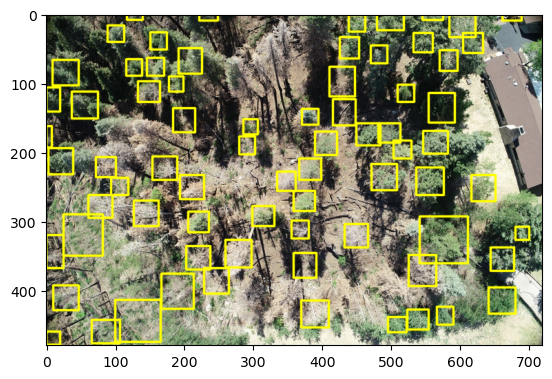

In [36]:
#Show the image with the bounding boxes
plot = model.predict_image(path=image_path5, return_plot = True, color=(0, 255, 255), thickness=2)
plt.imshow(plot[:,:,::-1])

## Predict Tree Crowns on Georeferenced Images

In [12]:
#Set the path for a georeferenced image you want to predict tree crowns
#raster_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")
raster_path = get_data("/data-store/iplant/home/jgillan/USGA/imagery_products/hole_17_ortho_test.tif")

In [13]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 455/455 [00:26<00:00, 17.46it/s]
4825 predictions in overlapping windows, applying non-max supression
2832 predictions kept after non-max suppression


/opt/conda/lib/python3.11/site-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


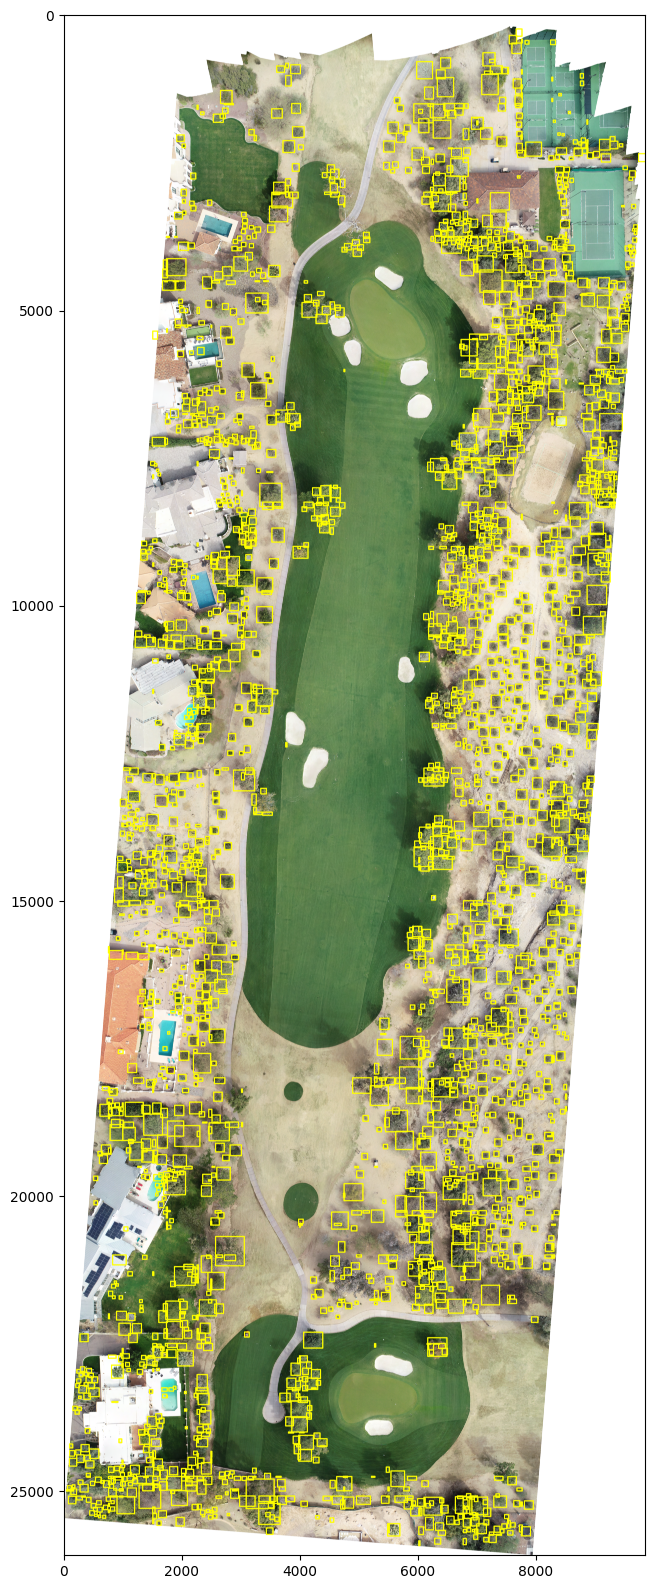

In [14]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Improve Model with Training
If the pre-trained model does not identify all trees, then we want to improve the model by adding some training data and fine-tuning the model.
Manual labeling of trees (bounding boxes) can be done in QGIS. The output should be a polygon shapefile (.shp). Instructions for using QGIS is [here](https://github.com/ua-datalab/Geospatial_Workshops/wiki/Drone-Image-Analysis-%E2%80%90-Deep-Forest)

In [22]:
#Define data paths in preparation to convert .shp to annotation dataframe that can be used for training
## I have found that it is important that the orthomosaic and shapefiles used should have map projections (e.g., UTM). Otherwise, there will be a shift problem in the `shapefile_to_annotations` step.  

# training data imagery path
#train_image_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")
train_image_path = get_data("/data-store/iplant/home/jgillan/USGA/imagery_products/hole_17_ortho_utm.tif")


# the directory that has the training data imagery
train_image_dir = os.path.dirname(train_image_path)

# the name of the training imagery
image_name = os.path.basename(train_image_path)

# shapefile path
#shp_path = "/data-store/iplant/home/jgillan/media/srer_train.shp"
shp_path = "/data-store/iplant/home/jgillan/media/golf_train_utm.shp"

# Location where you will save the annotation dataframe
savedir = "/data-store/iplant/home/jgillan/media"

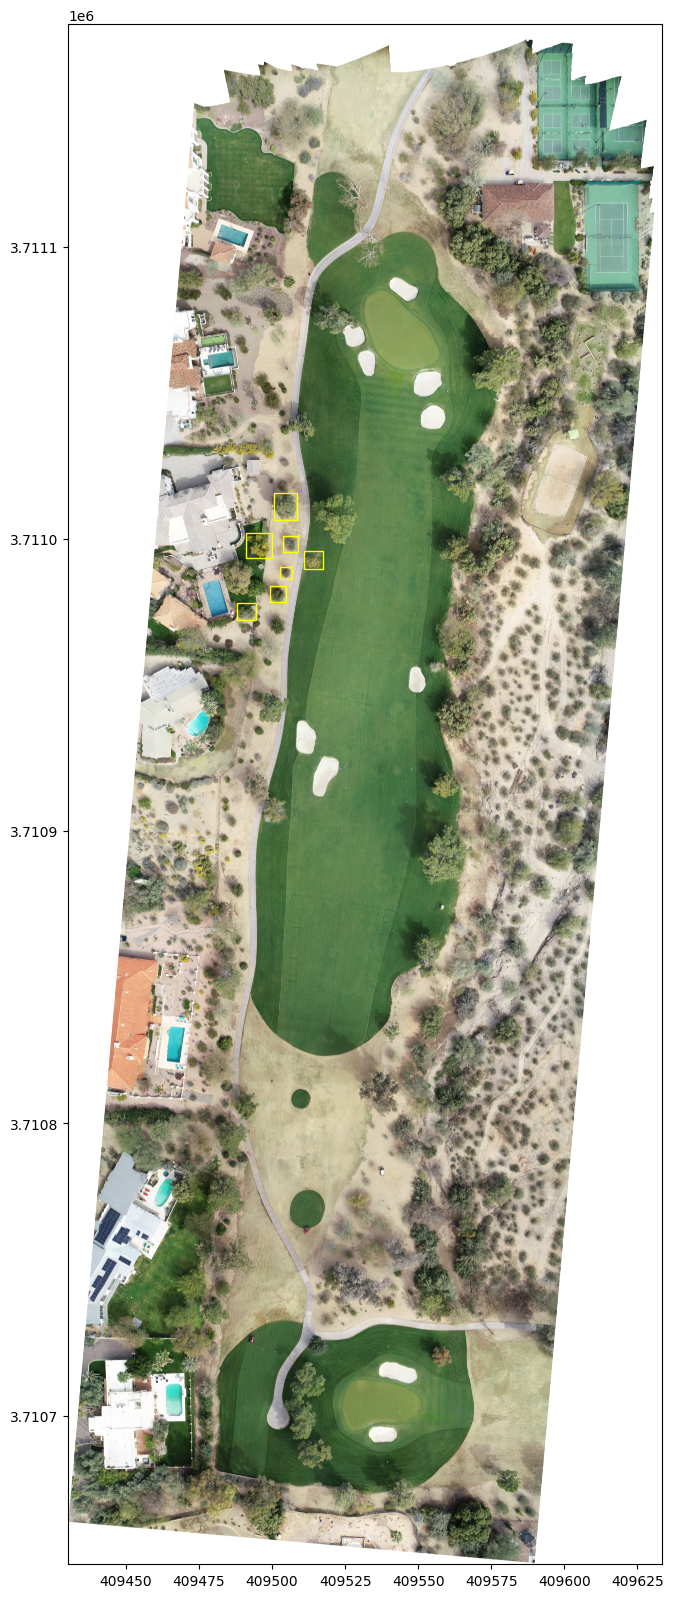

In [23]:
## Show shapefile overlayed on orthomosaic

# Open the GeoTIFF file
with rasterio.open(train_image_path) as src:
    fig, ax = plt.subplots(figsize=(20, 20))
    show(src, ax=ax)

    # Read the shapefile
    shapefile = gpd.read_file(shp_path)

    # Plot the shapefile on top of the GeoTIFF
    shapefile.plot(ax=ax, facecolor='none', edgecolor='yellow')

plt.show()

In [24]:
##Convert .shp (shapefile) to annoation that can be ingested by DeepForest
df = shapefile_to_annotations(shapefile=shp_path, rgb=train_image_path, geometry_type='bbox', savedir=savedir)

In [25]:
#Show the annotation
df

image_path  xmin  ymin  xmax   ymax label
0  hole_17_ortho_utm.tif  3655  8704  3899   8969  Tree
1  hole_17_ortho_utm.tif  4011  8958  4332   9254  Tree
2  hole_17_ortho_utm.tif  3502  7961  3894   8424  Tree
3  hole_17_ortho_utm.tif  3013  8653  3461   9075  Tree
4  hole_17_ortho_utm.tif  3604  9223  3802   9427  Tree
5  hole_17_ortho_utm.tif  3421  9554  3696   9819  Tree
6  hole_17_ortho_utm.tif  2861  9839  3197  10129  Tree

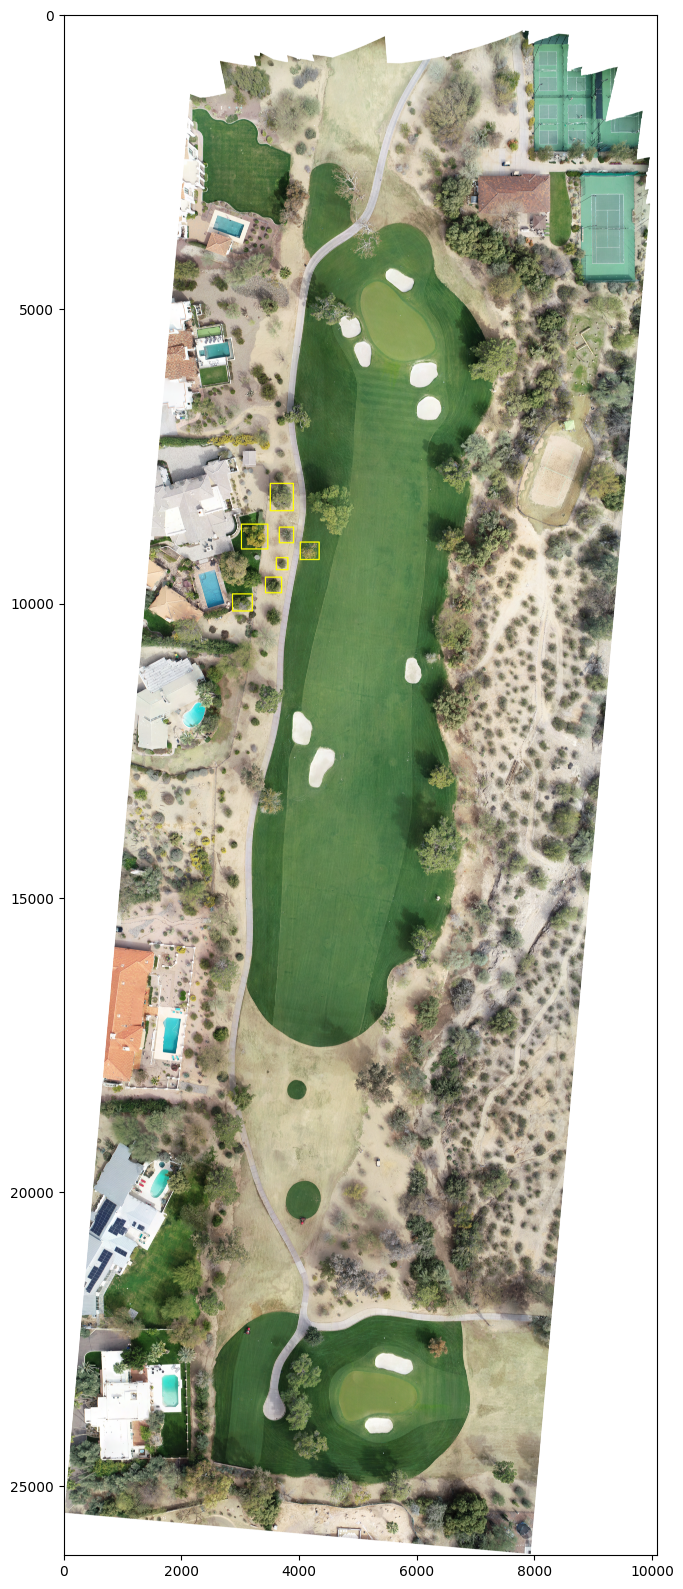

In [26]:
## Display the annotation on the orthomosaic

rasterio_src = rasterio.open(train_image_path)

image = rasterio_src.read()
image = numpy.rollaxis(image, 0, 3)

fig = plot_predictions(image, df, color=(255, 255, 0), thickness=20)
plt.figure(figsize=(20, 20))
plt.imshow(fig)

In [24]:
#Write training data dataframe to csv file
df.to_csv(os.path.join(train_image_dir, "labels_pixel_coords.csv"), index=False)

In [25]:
##This will split a large georeferenced image (and it's labels) into smaller pieces. This prevents running out of memory.
annotation_path = os.path.join(train_image_dir, "labels_pixel_coords.csv")

#create a directory where the smaller images will be stored
crop_dir = os.path.join(train_image_dir, 'train_data')

# Do the split and write out the cropped images as .png files. 
#Also write a new annotation table (csv) that lists all of the label coordinates and the cropped image they belong to. 
output_crops = split_raster(path_to_raster=train_image_path,
                            annotations_file=annotation_path,
                            base_dir=crop_dir,
                            patch_size=1100,  #1100x1100 pixels
                            patch_overlap=0.25, #cropped image overlap. This is useful because label boxes may be on the edge of cropped images.
                            allow_empty=False)

print(f"Number of tree crown annotations: {len(output_crops)}")
output_crops

/opt/conda/lib/python3.11/site-packages/deepforest/preprocess.py:216: UserWarning: Input rasterio had non-3 band shape of (26636, 10248, 4), ignoring alpha channel
  warnings.warn(


Number of tree crown annotations: 4


image_path  xmin  ymin  xmax  ymax label
3  hole_17_ortho_137.png   247   382   787   922  Tree
1  hole_17_ortho_139.png   165   361   549   709  Tree
2  hole_17_ortho_140.png   192    86   531   415  Tree
0  hole_17_ortho_170.png     0   582   374   939  Tree

In [29]:
#Create a variable that defines the path of new annotation table
#base_name, _ = os.path.splitext(image_name)
#csv_name = base_name + ".csv"
#annotation_table = os.path.join(crop_dir, csv_name)

### Split annotation data into training and validation

In [26]:
#identify all of the cropped images as an array
image_paths = output_crops.image_path.unique()

#Of the unique cropped image paths, randomly select 25% of them
validation_paths = numpy.random.choice(image_paths, int(len(image_paths)*0.25))

#Get the individual tree annotation from the 25% cropped images
validation_annotations = output_crops.loc[output_crops.image_path.isin(validation_paths)]

#Get the individual tree annotations from the remaining 75% cropped images
train_annotations = output_crops.loc[~output_crops.image_path.isin(validation_paths)]

#Print out the number of training and testing tree crown annotations
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(validation_annotations.shape[0]))

There are 3 training crown annotations
There are 1 test crown annotations


In [27]:
## Write training and validation annotations to separate csv files

#save to file and create the file dir
training_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(training_file,index=False)
validation_annotations.to_csv(validation_file,index=False)

## Train 

In [34]:
##Set parameters for the training run

#Define the pre-trained model
model = main.deepforest()

model.config['gpus'] = '-1' #move to GPU and use all the GPU resources

#model.config["save-snapshot"] = False
#model.config["train"]["fast_dev_run"] = True

#The annotation table
model.config["train"]["csv_file"] = training_file
#The directory where the training imagery is located
model.config["train"]["root_dir"] = os.path.dirname(training_file)

model.config["score_thresh"] = 0.4
model.config["train"]['epochs'] = 2

model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)


model.create_trainer()

model.use_release()


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [35]:
##TRAIN THE MODEL!
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s, v_num=1]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s, v_num=1]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s, v_num=1]       

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s, v_num=1]
--- Training on GPU: 4.45 seconds ---


In [39]:
save_dir = os.path.join(train_image_dir, 'pred_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(training_file, os.path.dirname(training_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]


In [37]:
save_dir = os.path.join(train_image_dir, 'valid_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(validation_file, os.path.dirname(validation_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


In [41]:
results

{'results':    prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
 0              0         0  0.696789  0.254225   165   549   361   709   
 0              0         0  0.845354  0.296292   192   531    86   415   
 0              0         0  0.738730  0.459242     0   374   582   939   
 
   predicted_label true_label             image_path  match  
 0            Tree       Tree  hole_17_ortho_139.png   True  
 0            Tree       Tree  hole_17_ortho_140.png   True  
 0            Tree       Tree  hole_17_ortho_170.png   True  ,
 'box_precision': 0.20833333333333334,
 'box_recall': 1.0,
 'class_recall':    label  recall  precision  size
 0      0     1.0        1.0     3,
 'predictions':           xmin        ymin         xmax         ymax label     score  \
 0   195.592361  413.446838   516.368042   703.722229  Tree  0.254225   
 1   252.636108  774.248596   563.070312  1083.484497  Tree  0.150972   
 2     0.000000  219.302948   203.072052   577.858459  Tre

In [40]:
results['results']

prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
0              0         0  0.696789  0.254225   165   549   361   709   
0              0         0  0.845354  0.296292   192   531    86   415   
0              0         0  0.738730  0.459242     0   374   582   939   

  predicted_label true_label             image_path  match  
0            Tree       Tree  hole_17_ortho_139.png   True  
0            Tree       Tree  hole_17_ortho_140.png   True  
0            Tree       Tree  hole_17_ortho_170.png   True

In [42]:
results['box_precision']

0.20833333333333334

In [43]:
results["box_recall"]

1.0

In [44]:
results["class_recall"]

label  recall  precision  size
0      0     1.0        1.0     3